# CBDC ABM Simulation Analysis

This notebook imports the simualtion output and analyzes the output.

The simulation for a toy economy that consists of a number of households, firms, banks and a central bank. Households are employed at firms, are paid for labour, produce output and purchase output. Wages are paid and output is paid for using a combination of deposits at banks and Central Bank Digital Currency.

### Set Parameter values

In [516]:
parameter_values = (('num_sweeps', '31'),
                    ('num_simulations', '50'),
                    ('num_households', '500'),
                    ('num_firms', '40'),
                    ('num_banks', '4'),
                    ('num_ach', '1'),
                    ('num_central_bank', '1'),
                    ('batch', '2'),
                    ('interest_rate_list', 'loans,open_market_operations,loans_central_bank,interbank_deposits'),
                    ('reserves_interest', '0.00'),
                    ('loans_central_bank_interest', '0.003952021'),
                    ('open_market_operations_interest', '0.018372469'),
                    ('loans_interbank_interest', '0.003873535'),
                    ('loans_interest', '0.012958176'),
                    ('deposits_interest', '0.0'),
                    ('clearing_house_fee', '140000'),
                    ('household_directory', 'cluster_folder/agents/gen_households/'),
                    ('firm_directory', 'cluster_folder/agents/gen_firms/'),
                    ('bank_directory', 'cluster_folder/agents/gen_banks/'),
                    ('ach_directory', 'cluster_folder/agents/ach/'),
                    ('central_bank_directory', 'cluster_folder/agents/central_bank/'),
                    ('measurement_config', 'cluster_folder/measurements/test_measurements.xml')
                   )

## Import Simulation Output

Set directory for simulation results

In [517]:
from functools import reduce
import pandas as pd
import glob
import json
thesis_dir = '/Users/jonathanrossouw/Desktop/Sim_res/batch'

Import the measurements csv

In [518]:

thesis_output = []
thesis_dir_output = glob.glob(thesis_dir + "/*.csv")
for filename in thesis_dir_output[0:80]:
    thesis_output.append(pd.read_csv(filename, index_col=0))

Import firm balance sheets

In [519]:
firms_output = []
firms_dir = glob.glob(thesis_dir + "/firm*.json")
for filename in firms_dir[0:80]:
    firms_output.append(json.load(open(filename)))


Import household balance sheets

In [520]:
import json
households_output = []
household_dir = glob.glob(thesis_dir + "/household*.json")
for filename in household_dir[0:80]:
    households_output.append(json.load(open(filename)))


Import bank balance sheets

In [521]:
banks_output = []
banks_dir = glob.glob(thesis_dir + "/bank*.json")
for filename in banks_dir[0:80]:
    banks_output.append(json.load(open(filename)))


Import clearing house balance sheets

In [522]:
ach_output = []
ach_dir = glob.glob(thesis_dir + "/ach*.json")
for filename in ach_dir[0:80]:
    ach_output.append(json.load(open(filename)))


Import central bank balance sheets

In [523]:
central_bank_output = []
central_bank_dir = glob.glob(thesis_dir + "/central*.json")
for filename in central_bank_dir[0:80]:
    central_bank_output.append(json.load(open(filename)))


## Functions to Read in JSON files into DataFrames

Function to read in json files containing balance sheets and create data frames

In [524]:
# Function that creates a dataframe where each column is the total of each of the different balance sheet entries for a specific type of agent for each simulation step
def json_to_dataframe_total(df, num_sim):
    df_new = pd.DataFrame() # Create empty df
    for item in df: # Loop through list of output from entire step
        balance_h = [] # Create empty list to store balance sheets
        for j in list(item.values()): # Loop through list of agents
            for k in j: # Loop through individual agents
                agent_bal = pd.DataFrame.from_dict(list(k.values())[0], orient="columns") # Create df of balance sheet
                balance_h.append(agent_bal) # Append current agent balance sheet to previous balance sheets


        house_balance = reduce(lambda x, y: x.add(y, fill_value=0), balance_h) # Sum all df together
        house_balance = pd.DataFrame(house_balance.fillna(0).sum(axis=1)) # Replace NA with 0's and sum asset and liabilities side together to made single col
        df_new = pd.concat([df_new, house_balance.T]) # Concat current step total to previous step output rowwise
    df_new.index = range(num_sim) # Reindex to number of steps
    return df_new 

Function to read in json files containing balance sheets and create data frames for specified agent id

In [525]:
# Function that creates a dataframe where each column is a balance sheet entry for a specified agent id for each simulation step
def json_to_dataframe_id(df, num_sim, agent_id):
    df_new = pd.DataFrame() # Create empty df
    for item in df: # Loop through list of output from entire step
        balance_h = [] # Create empty list to store balance sheets
        for j in list(item.values()): # Loop through list of agents
            for k in j: # Loop through individual agents
                if agent_id in k:
                    agent_bal = pd.DataFrame.from_dict(list(k.values())[0], orient="columns") # Create df of balance sheet
                    balance_h.append(agent_bal) # Append current agent balance sheet to previous balance sheets


        house_balance = reduce(lambda x, y: x.add(y, fill_value=0), balance_h) # Sum all df together
        house_balance = pd.DataFrame(house_balance.fillna(0).sum(axis=1)) # Replace NA with 0's and sum asset and liabilities side together to made single col
        df_new = pd.concat([df_new, house_balance.T]) # Concat current step total to previous step output rowwise
    df_new.index = range(num_sim) # Reindex to number of steps
    return df_new 

Function to read in json file containing balance sheet and create dataframe of specific account for all agents of certain type over course of simulation 

In [526]:
# Function that creates dataframe where columns are a specific account type for each agent of certain type for each simulation step
# i.e: cols = [bank_0_deposits, bank_1_deposits, ..., bank_n_deposits]
def json_to_dataframe_account(df, num_sim, account):
    df_new = pd.DataFrame() # Create empty df
    for item in df: # Loop through list of output from entire step
        balance_h = {} # Create empty list to store balance sheets
        for j in list(item.values()): # Loop through list of agents
            for k in j: # Loop through individual agents
                for h in k:
                    for v in k[h].values():
                        try:
                            balance_h[h] = v[account]   
                        except:
                            pass
        agent_bal = pd.DataFrame([balance_h]) # Create df of balance sheet
        df_new = pd.concat([df_new, agent_bal]) # Concat current step total to previous step output rowwise
    df_new.index = range(num_sim) # Reindex to number of steps
    return df_new 

## Summary of Data

In [527]:
import random

num_sim = int(parameter_values[0][1])

rand_choice = random.randint(0, num_sim)

# Households
df_household = json_to_dataframe_total(households_output[rand_choice], num_sim)

# Firms
df_firm = json_to_dataframe_total(firms_output[rand_choice], num_sim)

# Bank

df_bank = json_to_dataframe_total(banks_output[rand_choice], num_sim)
col_names = list(df_bank.columns)
col_names = [x for x in col_names if 'ach_payee' in x]

df_bank['ach_payee'] = df_bank[col_names].sum(axis=1)
df_bank = df_bank.drop(columns = col_names)

col_names = list(df_bank.columns)
col_names = [x for x in col_names if 'ach_payer' in x]

df_bank['ach_payer'] = df_bank[col_names].sum(axis=1)
df_bank = df_bank.drop(columns = col_names)


# ACH 
df_ach = json_to_dataframe_total(ach_output[rand_choice], num_sim)

# Central Bank
df_central = json_to_dataframe_total(central_bank_output[rand_choice], num_sim)

print("Households")
print(df_household.head())
print("Firms")
print(df_firm.head())
print("Banks")
print(df_bank.head())
print("Clearing House")
print(df_ach.head())
print("Central Bank")
print(df_central.head())



Households
       deposits  bank_notes  receivables   equity_firm   equity_bank  loans
0  5.632597e+09         0.0          0.0  2.962512e+09  2.962512e+09    0.0
1  5.555891e+09         0.0          0.0  3.050187e+09  3.180110e+09    0.0
2  5.478513e+09         0.0          0.0  3.136880e+09  3.381360e+09    0.0
3  5.400457e+09         0.0          0.0  3.224397e+09  3.612300e+09    0.0
4  5.321717e+09         0.0          0.0  3.311061e+09  3.828764e+09    0.0
Firms
        capital      deposits  bank_notes   receivables         loans  \
0  2.580839e+09  2.580839e+09         0.0  0.000000e+00  2.580839e+09   
1  2.580839e+09  2.639746e+09         0.0  8.148280e+07  2.636898e+09   
2  2.580839e+09  2.862135e+09         0.0  0.000000e+00  2.694174e+09   
3  2.580839e+09  2.934192e+09         0.0  7.079791e+07  2.752694e+09   
4  2.580839e+09  3.148476e+09         0.0  0.000000e+00  2.812486e+09   

         equity  
0  2.580839e+09  
1  2.665171e+09  
2  2.748800e+09  
3  2.833135e+09 

In [528]:
num_rps = []
for df in thesis_output:
    num_rps.append(int(df["number_of_cleared_payments"][-1::]))
num_rps.sort()
num_rps_stats = {}
num_rps_stats["min"] = num_rps[0]
num_rps_stats["max"] = num_rps[-1]
num_rps_stats["mean"] = sum(num_rps)/len(num_rps)
num_rps_stats

{'min': 0, 'max': 0, 'mean': 0.0}

## Plotting Results

In [529]:
import matplotlib.pyplot as plt

### Clearing House

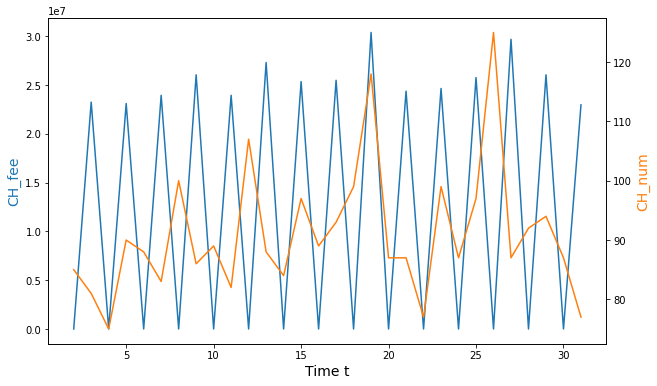

In [530]:
thesis_data_plot = thesis_output[rand_choice]

thesis_data_plot[["CH_fee", "CH_num"]] = thesis_data_plot[["clearing_house_fee_total", "number_of_batched_payments"]].diff()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

ax.plot(thesis_data_plot.index, thesis_data_plot[['CH_fee']])
ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('CH_fee', fontsize='14',color='C0')

ax2 = ax.twinx()
ax2.plot(thesis_data_plot.index, thesis_data_plot[['CH_num']], color='C1')
ax2.set_xlabel('Time t', fontsize='14')
ax2.set_ylabel('CH_num', fontsize='14', color='C1')

# plt.title("Plot of Clearing House", size=20)

fig.savefig('figures/ACH_plot.png')



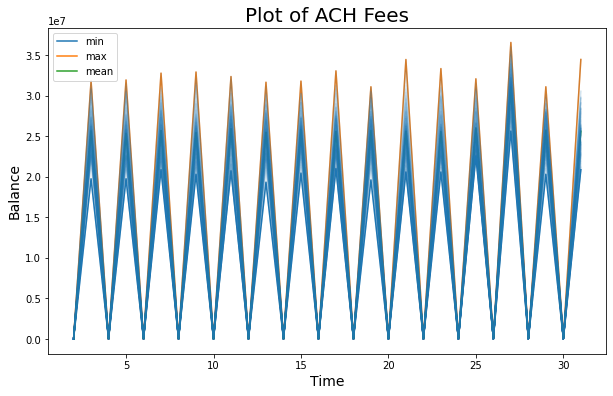

In [531]:
# Ach Fees Plot
ach_fees = {}
for i, ach in enumerate(thesis_output):
    ach_fees[i] = ach["clearing_house_fee_total"].diff()
ach_fees_df = pd.DataFrame.from_dict(ach_fees)    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Household
ach_fees_df['max'] = ach_fees_df.max(axis=1)
ach_fees_df['min'] = ach_fees_df.min(axis=1)
ach_fees_df['mean'] = ach_fees_df.mean(axis=1)
ax.plot(ach_fees_df.index, ach_fees_df[['min', 'max', 'mean']])
ax.plot(ach_fees_df.index, ach_fees_df, color='C0', alpha=0.1)
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'])
plt.title("Plot of ACH Fees", size=20)

fig.savefig('figures/ACH_fees.png')

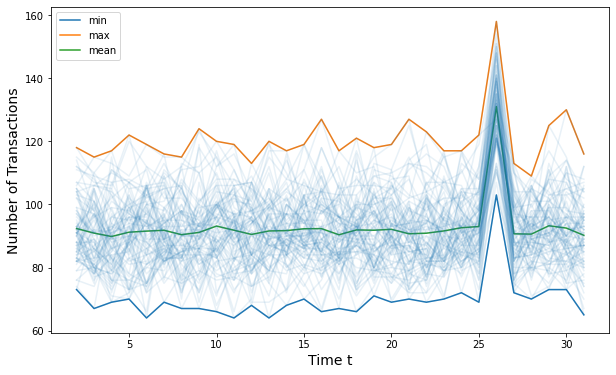

In [532]:
# Ach Fees Plot
ach_num = {}
for i, ach in enumerate(thesis_output):
    ach_num[i] = ach["number_of_batched_payments"].diff()
ach_num_df = pd.DataFrame.from_dict(ach_num)    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Household
ach_num_df['max'] = ach_num_df.max(axis=1)
ach_num_df['min'] = ach_num_df.min(axis=1)
ach_num_df['mean'] = ach_num_df.mean(axis=1)
ax.plot(ach_num_df.index, ach_num_df[['min', 'max', 'mean']])
ax.plot(ach_num_df.index, ach_num_df, color='C0', alpha=0.1)
ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Number of Transactions', fontsize='14')
ax.legend(['min', 'max', 'mean'], loc=2)
#plt.title("Plot of ACH Num", size=20)

fig.savefig('figures/ACH_num.png')

Number of Clearing House Transactions and Fees

In [533]:
num_ch = []
for df in thesis_output:
    num_ch.append(int(df["number_of_batched_payments"][-1::]))
num_ch.sort()
num_ch_stats = {}
num_ch_stats["min"] = num_ch[0]
num_ch_stats["max"] = num_ch[-1]
num_ch_stats["mean"] = sum(num_ch)/len(num_ch)
num_ch_stats

{'min': 2541, 'max': 97483, 'mean': 36754.0875}

CH Fees

In [491]:
fees_ch = []
for df in thesis_output:
    fees_ch.append(int(df["clearing_house_fee_total"][-1::]))
fees_ch.sort()
fees_ch_stats = {}
fees_ch_stats["min"] = fees_ch[0]
fees_ch_stats["max"] = fees_ch[-1]
fees_ch_stats["mean"] = sum(fees_ch)/len(fees_ch)
fees_ch_stats

{'min': 0, 'max': 0, 'mean': 0.0}

### Households

In [492]:
hh_npv = []
for item in households_output:
    hh_ids = list(json_to_dataframe_account(item, num_sim, "loans").columns)
    for house in hh_ids:
        household_npv = json_to_dataframe_id(item, num_sim, house)
        household_npv['npv'] = household_npv[['deposits', 'bank_notes',  'receivables',  'equity_firm' , 'equity_bank']].sum(axis=1) - household_npv['deposits'].values
        hh_npv.append(household_npv)

In [493]:
hh_npv_rand = []
hh_ids = list(json_to_dataframe_account(households_output[rand_choice], num_sim, "loans").columns)
for house in hh_ids:
    household_npv = json_to_dataframe_id(households_output[rand_choice], num_sim, house)
    household_npv['npv'] = household_npv[['deposits', 'bank_notes',  'receivables',  'equity_firm' , 'equity_bank']].sum(axis=1) - household_npv['deposits'].values
    hh_npv_rand.append(household_npv)

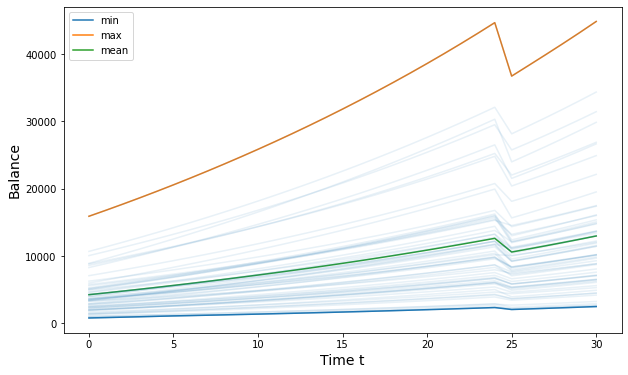

In [494]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

household_npv_individual = {}

for i, item in enumerate(hh_npv_rand):
    household_npv_individual[i] = item["npv"]

household_npv_df = pd.DataFrame.from_dict(household_npv_individual)/20000
household_npv_df['max'] = household_npv_df.max(1)
household_npv_df['mean'] = household_npv_df.mean(1)
household_npv_df['min'] = household_npv_df.min(1)

ax.plot(household_npv_df.index, household_npv_df[['min', 'max', 'mean']])
ax.plot(household_npv_df.index, household_npv_df, color='C0', alpha=0.1)
ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'])
# plt.title("Plot of Household NPV", size=20)

fig.savefig('figures/Households_NPVs.png')


Household NPV

In [495]:
hh_npv_final = []
for item in hh_npv:
    hh_npv_final.append(float(item["npv"][-1:]))
    
hh_npv_stats = {}
hh_npv_final.sort()
hh_npv_stats["min"] = hh_npv_final[0]
hh_npv_stats["max"] = hh_npv_final[-1]
hh_npv_stats["mean"] = (sum(hh_npv_final)/len(hh_npv_final))
hh_npv_stats

{'min': 12033993.958999999,
 'max': 1937205883.6579998,
 'mean': 259518449.01750728}

Household Percentage Change NPV

In [496]:
hh_npv_perc = []
for item in hh_npv:
    hh_npv_perc_hh = (float(item['npv'][-1:]) - float(item['npv'][0]))/item['npv'][0]
    hh_npv_perc.append(hh_npv_perc_hh)

hh_npv_perc_stats = {}
hh_npv_perc.sort()
hh_npv_perc_stats["min"] = hh_npv_perc[0]
hh_npv_perc_stats["max"] = hh_npv_perc[-1]
hh_npv_perc_stats["mean"] = (sum(hh_npv_perc)/len(hh_npv_perc))
hh_npv_perc_stats

{'min': 0.9966800785975436,
 'max': 3.019819616014488,
 'mean': 1.8334786164441732}

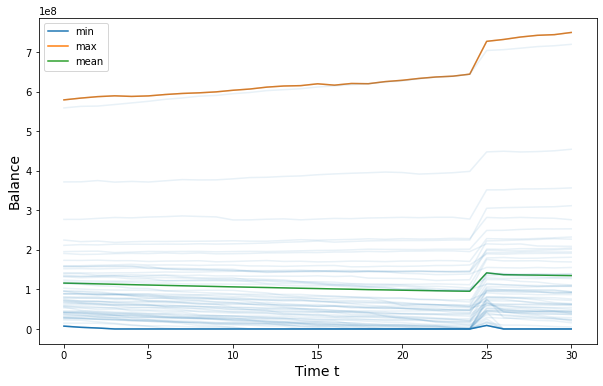

In [497]:
# Household Deposits Plot
household_deposits = {}
for i, household in enumerate(households_output):
    df_household_deposits = json_to_dataframe_account(household, num_sim, "deposits")
    for j, col in enumerate(df_household_deposits):
        household_deposits[(i+1)*(j+1)] = df_household_deposits[col].values/20000
household_deposits = pd.DataFrame.from_dict(household_deposits)    

household_deposits = json_to_dataframe_account(households_output[rand_choice], num_sim, "deposits")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Household
household_deposits['max'] = household_deposits.max(axis=1)
household_deposits['min'] = household_deposits.min(axis=1)
household_deposits['mean'] = household_deposits.mean(axis=1)
ax.plot(household_deposits.index, household_deposits[['min', 'max', 'mean']])
ax.plot(household_deposits.index, household_deposits, color='C0', alpha=0.1)
ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'])
# plt.title("Plot of Household deposits", size=20)

fig.savefig('figures/Households_deposits.png')

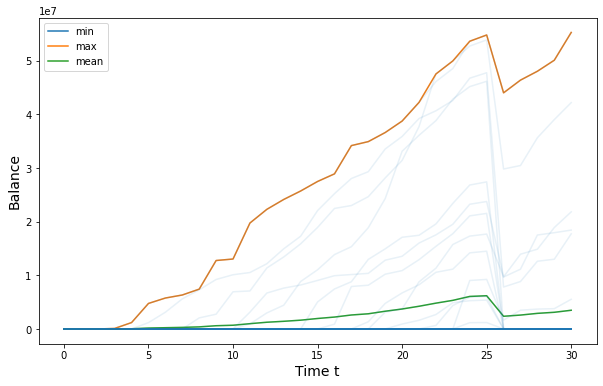

In [498]:
# Household Loans Plot
household_loans = {}
for i, household in enumerate(households_output):
    df_household_loans = json_to_dataframe_account(household, num_sim, "loans")
    for j, col in enumerate(df_household_deposits):
        household_loans[(i+1)*(j+1)] = df_household_loans[col].values/20000
household_loans = pd.DataFrame.from_dict(household_loans)    

household_loans = json_to_dataframe_account(households_output[rand_choice], num_sim, "loans")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Household
household_loans['max'] = household_loans.max(axis=1)
household_loans['min'] = household_loans.min(axis=1)
household_loans['mean'] = household_loans.mean(axis=1)
ax.plot(household_loans.index, household_loans[['min', 'max', 'mean']])
ax.plot(household_loans.index, household_loans, color='C0', alpha=0.1)
ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'], loc=2)
# plt.title("Plot of Household Loans", size=20)

fig.savefig('figures/Households_loans.png')

## Firms

In [499]:
firm_eq = []
for firm in firms_output:
    df_firm_eq = json_to_dataframe_account(firm, num_sim, 'equity')
    firm_eq += list((df_firm_eq.iloc[-1,:] - df_firm_eq.iloc[0,:])/df_firm_eq.iloc[0,:])
    
firm_eq_stats = {}
firm_eq.sort()
firm_eq_stats["min"] = firm_eq[0]
firm_eq_stats["max"] = firm_eq[-1]
firm_eq_stats["mean"] = (sum(firm_eq)/len(firm_eq))
firm_eq_stats

{'min': -0.5154119752907557,
 'max': 0.3918660964374422,
 'mean': -0.24322855377005273}

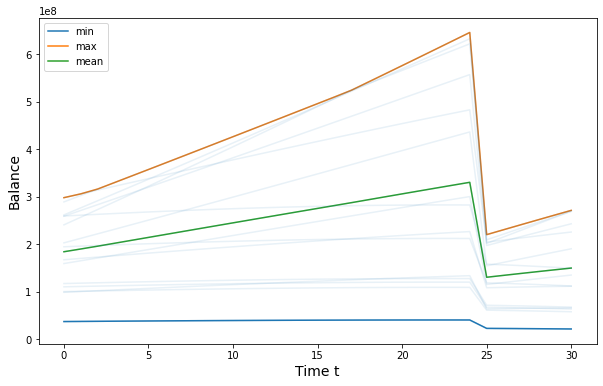

In [500]:
# Firm Equity Plot
firm_equity = {}
for i, firm in enumerate(firms_output):
    df_firm_equity = json_to_dataframe_account(firm, num_sim, "equity")
    for j, col in enumerate(df_firm_equity):
        firm_equity[(i+1)*(j+1)] = df_firm_equity[col].values
firm_equity = pd.DataFrame.from_dict(firm_equity)    

firm_equity = json_to_dataframe_account(firms_output[rand_choice], num_sim, "equity")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Firms
firm_equity['max'] = firm_equity.max(axis=1)
firm_equity['min'] = firm_equity.min(axis=1)
firm_equity['mean'] = firm_equity.mean(axis=1)
ax.plot(firm_equity.index, firm_equity[['min', 'max', 'mean']])
ax.plot(firm_equity.index, firm_equity, color='C0', alpha=0.1)

ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'], loc=2)
# plt.title("Plot of Firm Equity", size=20)

fig.savefig('figures/Firm_Equity.png')

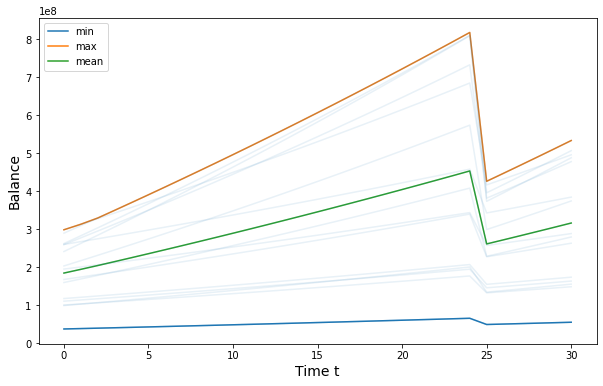

In [501]:
# Firm Deposits Plot
firm_deposits = {}
for i, firm in enumerate(firms_output):
    df_firm_deposits = json_to_dataframe_account(firm, num_sim, "deposits")
    for j, col in enumerate(df_firm_deposits):
        firm_deposits[(i+1)*(j+1)] = df_firm_deposits[col].values
firm_deposits = pd.DataFrame.from_dict(firm_deposits)    

firm_deposits = json_to_dataframe_account(firms_output[rand_choice], num_sim, "deposits")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Firms
firm_deposits['max'] = firm_deposits.max(axis=1)
firm_deposits['min'] = firm_deposits.min(axis=1)
firm_deposits['mean'] = firm_deposits.mean(axis=1)
ax.plot(firm_deposits.index, firm_deposits[['min', 'max', 'mean']])
ax.plot(firm_deposits.index, firm_deposits, color='C0', alpha=0.1)

ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'], loc=2)
#plt.title("Plot of Firm Deposits", size=20)

fig.savefig('figures/Firm_Deposits.png')

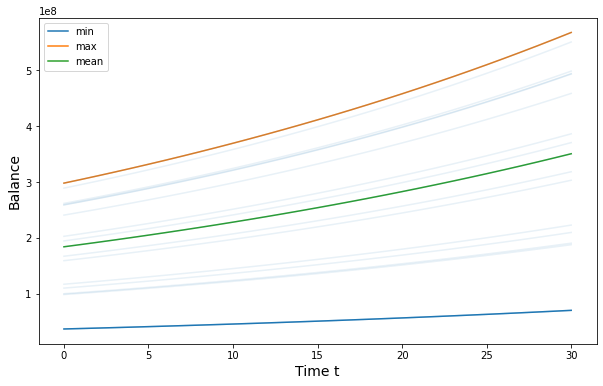

In [502]:
# Firm Loans Plot
firm_loans = {}
for i, firm in enumerate(firms_output):
    df_firm_loans = json_to_dataframe_account(firm, num_sim, "loans")
    for j, col in enumerate(df_firm_deposits):
        firm_loans[(i+1)*(j+1)] = df_firm_loans[col].values
firm_loans = pd.DataFrame.from_dict(firm_loans)    

firm_loans = json_to_dataframe_account(firms_output[rand_choice], num_sim, "loans")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

# Firms
firm_loans['max'] = firm_loans.max(axis=1)
firm_loans['min'] = firm_loans.min(axis=1)
firm_loans['mean'] = firm_loans.mean(axis=1)
ax.plot(firm_loans.index, firm_loans[['min', 'max', 'mean']])
ax.plot(firm_loans.index, firm_loans, color='C0', alpha=0.1)

ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'], loc=2)
#plt.title("Plot of Firm Loans", size=20)

fig.savefig('figures/Firm_Loans.png')

## Banks

In [503]:
bank_eq = []
for bank in banks_output:
    df_bank_eq = json_to_dataframe_account(bank, num_sim, 'equity')
    bank_eq += list((df_bank_eq.iloc[-1,:] - df_bank_eq.iloc[0,:])/df_bank_eq.iloc[0,:])
    
bank_eq_stats = {}
bank_eq.sort()
bank_eq_stats["min"] = bank_eq[0]
bank_eq_stats["max"] = bank_eq[-1]
bank_eq_stats["mean"] = (sum(bank_eq)/len(bank_eq))
bank_eq_stats

{'min': 2.5087711133796167,
 'max': 5.9215307685534375,
 'mean': 3.845726111728604}

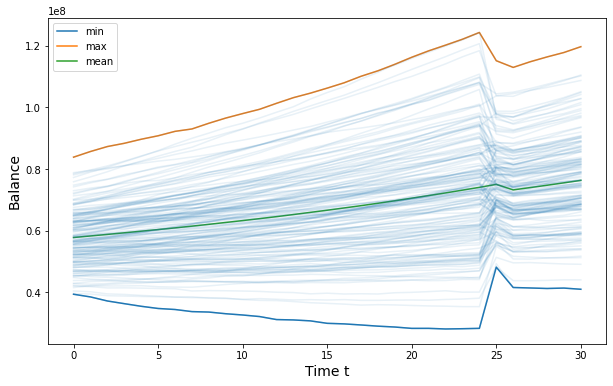

In [504]:
# Bank Reserves
bank_reserves = {}

for i, bank in enumerate(banks_output):
    df_bank_reserves = json_to_dataframe_account(bank, num_sim, "reserves")
    for j, col in enumerate(df_bank_reserves):
        bank_reserves[(i+1)*(j+1)] = df_bank_reserves[col].values
bank_reserves = pd.DataFrame.from_dict(bank_reserves)    
    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
bank_reserves["min"] = bank_reserves.min(axis = 1)
bank_reserves["max"] = bank_reserves.max(axis = 1)
bank_reserves["mean"] = bank_reserves.mean(axis = 1)
ax.plot(bank_reserves.index, bank_reserves[["min", "max", "mean"]])
ax.plot(bank_reserves.index, bank_reserves, color = "C0", alpha = 0.1)

ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'], loc=2)
#plt.title("Plot of Reserves", size=20)

fig.savefig('figures/Bank_Reserves.png')

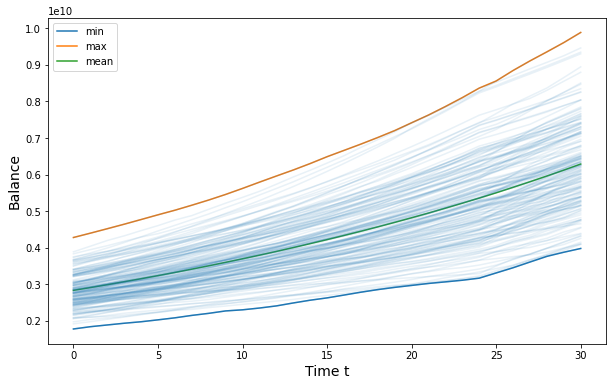

In [505]:
# Bank OMO
bank_omo = {}

for i, bank in enumerate(banks_output):
    df_bank_omo = json_to_dataframe_account(bank, num_sim, "open_market_operations")
    for j, col in enumerate(df_bank_reserves):
        bank_omo[(i+1)*(j+1)] = df_bank_omo[col].values
bank_omo = pd.DataFrame.from_dict(bank_omo)    
    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
bank_omo["min"] = bank_omo.min(axis = 1)
bank_omo["max"] = bank_omo.max(axis = 1)
bank_omo["mean"] = bank_omo.mean(axis = 1)
ax.plot(bank_omo.index, bank_omo[["min", "max", "mean"]])
ax.plot(bank_omo.index, bank_omo, color = "C0", alpha = 0.1)

ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'], loc=2)
#plt.title("Plot of Reserves", size=20)


fig.savefig('figures/Bank_OMO.png')

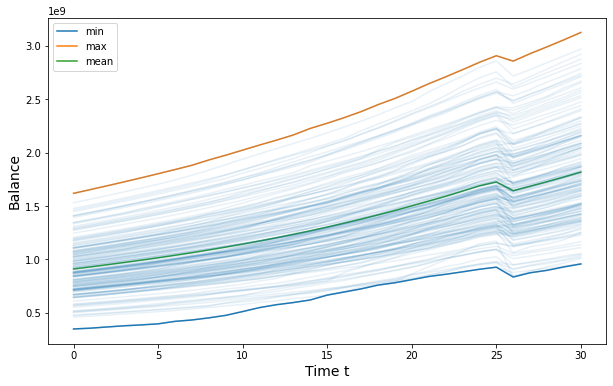

In [506]:
# Bank Loans
bank_loans = {}

for i, bank in enumerate(banks_output):
    df_bank_loans = json_to_dataframe_account(bank, num_sim, "loans")
    for j, col in enumerate(df_bank_loans):
        bank_loans[(i+1)*(j+1)] = df_bank_loans[col].values
bank_loans = pd.DataFrame.from_dict(bank_loans)    
    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
bank_loans["min"] = bank_loans.min(axis = 1)
bank_loans["max"] = bank_loans.max(axis = 1)
bank_loans["mean"] = bank_loans.mean(axis = 1)
ax.plot(bank_loans.index, bank_loans[["min", "max", "mean"]])
ax.plot(bank_loans.index, bank_loans, color = "C0", alpha = 0.1)

ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'], loc=2)
#plt.title("Plot of Reserves", size=20)


fig.savefig('figures/Bank_Loans.png')

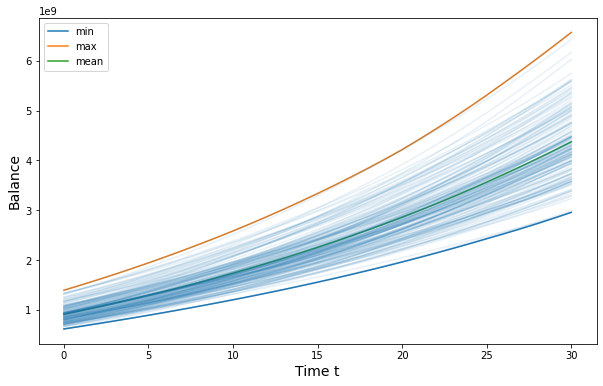

In [507]:
# Interbank Loans
bank_equity = {}

for i, bank in enumerate(banks_output):
    df_bank_equity = json_to_dataframe_account(bank, num_sim, "equity")
    for j, col in enumerate(df_bank_equity):
        bank_equity[(i+1)*(j+1)] = df_bank_equity[col].values
bank_equity = pd.DataFrame.from_dict(bank_equity)    
    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
bank_equity["min"] = bank_equity.min(axis = 1)
bank_equity["max"] = bank_equity.max(axis = 1)
bank_equity["mean"] = bank_equity.mean(axis = 1)
ax.plot(bank_equity.index, bank_equity[["min", "max", "mean"]])
ax.plot(bank_equity.index, bank_equity, color = "C0", alpha = 0.1)

ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'])
# plt.title("Plot of Bank Equity", size=20)


fig.savefig('figures/Bank_Equity.png')

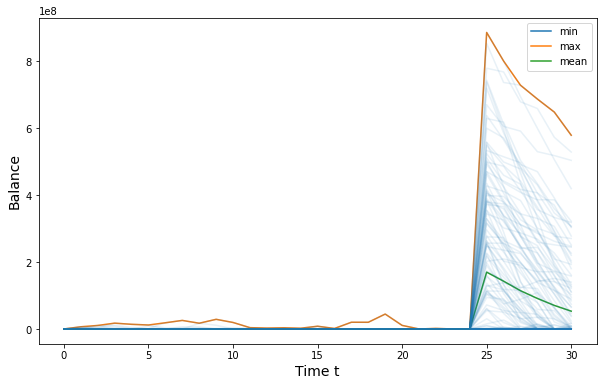

In [508]:
# Interbank Loans
bank_interbank_loans = {}

for i, bank in enumerate(banks_output):
    df_bank_interbank_loans = json_to_dataframe_account(bank, num_sim, "interbank_loans")
    for j, col in enumerate(df_bank_interbank_loans):
        bank_interbank_loans[(i+1)*(j+1)] = df_bank_interbank_loans[col].values
bank_interbank_loans = pd.DataFrame.from_dict(bank_interbank_loans)    
    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
bank_interbank_loans["min"] = bank_interbank_loans.min(axis = 1)
bank_interbank_loans["max"] = bank_interbank_loans.max(axis = 1)
bank_interbank_loans["mean"] = bank_interbank_loans.mean(axis = 1)
ax.plot(bank_interbank_loans.index, bank_interbank_loans[["min", "max", "mean"]])
ax.plot(bank_interbank_loans.index, bank_interbank_loans, color = "C0", alpha = 0.1)

ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'])
# plt.title("Plot of Interbank Loans", size=20)


fig.savefig('figures/IB_Loans.png')

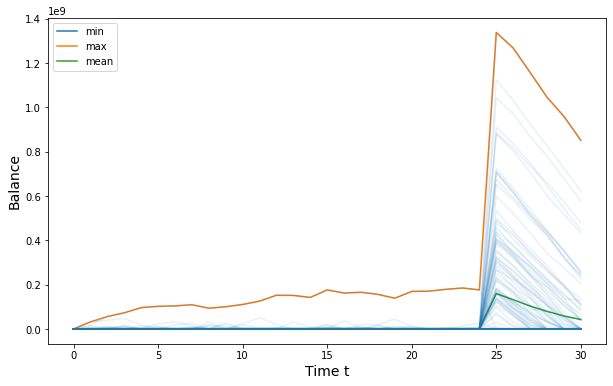

In [509]:
num_sim = int(parameter_values[0][1])
bank_loans_interbank_bank_id = {}

for i, bank in enumerate(banks_output):
    # df_bank_reserves = json_to_dataframe_account(bank, num_sim, "deposits")
    df = bank
    account = 'loans_interbank'
    # Function that creates dataframe where columns are a specific account type for each agent of certain type for each simulation step
    # i.e: cols = [bank_0_deposits, bank_1_deposits, ..., bank_n_deposits]
    #def json_to_dataframe_account(df, num_sim, account):
    df_new = pd.DataFrame() # Create empty df
    for item in df: # Loop through list of output from entire step
        balance_h = {} # Create empty list to store balance sheets
        for j in list(item.values()): # Loop through list of agents
            for k in j: # Loop through individual agents
                for h in k:
                    for v in k[h].values():
                        try:
                            balance_h[h] = v[account + "_" + h]   
                        except:
                            pass
        agent_bal = pd.DataFrame([balance_h]) # Create df of balance sheet
        df_new = pd.concat([df_new, agent_bal]) # Concat current step total to previous step output rowwise
    df_new.index = range(num_sim) # Reindex to number of steps

    #return df_new 

    for j, col in enumerate(df_new):
        bank_loans_interbank_bank_id[(i+1)*(j+1)] = df_new[col].values
bank_loans_interbank_bank_id = pd.DataFrame.from_dict(bank_loans_interbank_bank_id) 
bank_loans_interbank_bank_id  



fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
bank_loans_interbank_bank_id["min"] = bank_loans_interbank_bank_id.min(axis = 1)
bank_loans_interbank_bank_id["max"] = bank_loans_interbank_bank_id.max(axis = 1)
bank_loans_interbank_bank_id["mean"] = bank_loans_interbank_bank_id.mean(axis = 1)
ax.plot(bank_loans_interbank_bank_id.index, bank_loans_interbank_bank_id[["min", "max", "mean"]])
ax.plot(bank_loans_interbank_bank_id.index, bank_loans_interbank_bank_id, color = "C0", alpha = 0.1)

ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'], loc=2)
#plt.title("Plot of Reserves", size=20)


fig.savefig('figures/Bank_Loans_IB_Bank_ID.png')

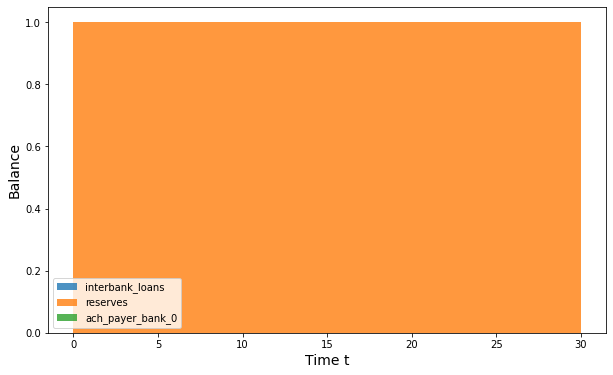

In [510]:
df_bank_0 = json_to_dataframe_id(banks_output[0], num_sim, 'bank_0')

df_bank_plot = df_bank_0[['interbank_loans', 'reserves', 'ach_payer_bank_0']] + 0.01
df_bank_plot = df_bank_plot.divide(df_bank_plot.sum(1), 0)


df_bank_plot_dict = df_bank_plot.to_dict()

for key in df_bank_plot_dict.keys():
    df_bank_plot_dict[key] = list(df_bank_plot_dict[key].values())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
ax.stackplot(df_bank_0.index, df_bank_plot_dict.values(),labels=df_bank_plot_dict.keys(), alpha = 0.8)
ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(df_bank_plot.columns, loc=3)
# plt.title("Area Plot of Selected Bank_0 Assets", size=20)

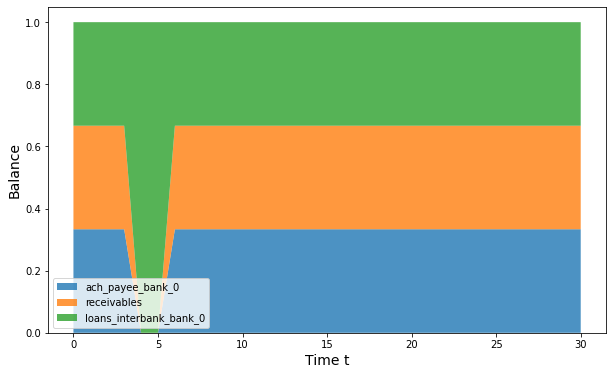

In [511]:
df_bank_plot = df_bank_0[['ach_payee_bank_0', 'receivables', 'loans_interbank_bank_0']] + 0.01
df_bank_plot = df_bank_plot.divide(df_bank_plot.sum(1), 0)


df_bank_plot_dict = df_bank_plot.to_dict()

for key in df_bank_plot_dict.keys():
    df_bank_plot_dict[key] = list(df_bank_plot_dict[key].values())

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
ax.stackplot(df_bank_0.index, df_bank_plot_dict.values(),labels=df_bank_plot_dict.keys(), alpha =0.8)
ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(df_bank_plot.columns, loc=3)
# plt.title("Area Plot of Selected Bank_0 Liabilities", size=20)


## Central Bank

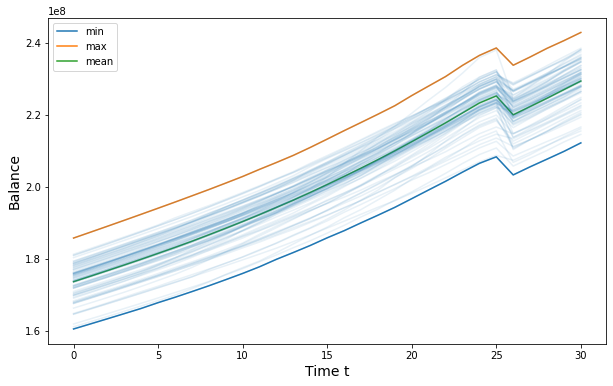

In [512]:
# Interbank Loans
central_bank_reserves = {}

for i, cb in enumerate(central_bank_output):
    df_central_bank_reserves = json_to_dataframe_account(cb, num_sim, "reserves")
    central_bank_reserves[i] = df_central_bank_reserves['central_bank'].values
central_bank_reserves = pd.DataFrame.from_dict(central_bank_reserves)    
    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
central_bank_reserves["min"] = central_bank_reserves.min(axis = 1)
central_bank_reserves["max"] = central_bank_reserves.max(axis = 1)
central_bank_reserves["mean"] = central_bank_reserves.mean(axis = 1)
ax.plot(central_bank_reserves.index, central_bank_reserves[["min", "max", "mean"]])
ax.plot(central_bank_reserves.index, central_bank_reserves, color = "C0", alpha = 0.1)
ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Reserves', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'])

# plt.title("Plot of Central Bank Reserves Sheet", size=20)

fig.savefig('figures/CB_reserves.png')

In [513]:
cb_res = []
for central_bank in central_bank_output:
    df_cb_res = json_to_dataframe_account(central_bank, num_sim, 'reserves')
    cb_res += list((df_cb_res.iloc[-1,:] - df_cb_res.iloc[0,:])/df_cb_res.iloc[0,:])
    
df_cb_res_stats = {}
cb_res.sort()
df_cb_res_stats["min"] = cb_res[0]
df_cb_res_stats["max"] = cb_res[-1]
df_cb_res_stats["mean"] = (sum(cb_res)/len(cb_res))
df_cb_res_stats

{'min': 0.29945636924406593,
 'max': 0.4021805060204942,
 'mean': 0.3210476865937867}

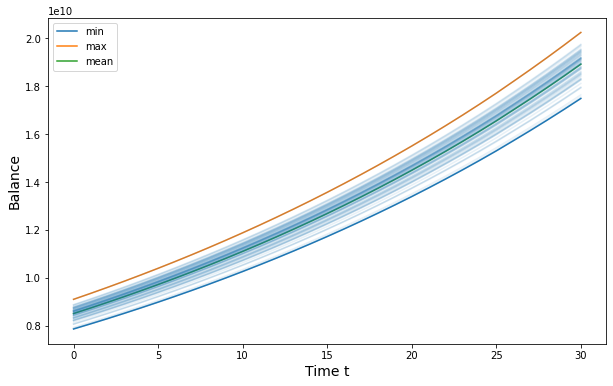

In [514]:
# Interbank Loans
central_bank_omo = {}

for i, cb in enumerate(central_bank_output):
    df_central_bank_omo = json_to_dataframe_account(cb, num_sim, "open_market_operations")
    central_bank_omo[i] = df_central_bank_omo['central_bank'].values
central_bank_omo = pd.DataFrame.from_dict(central_bank_omo)    
    

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
central_bank_omo["min"] = central_bank_omo.min(axis = 1)
central_bank_omo["max"] = central_bank_omo.max(axis = 1)
central_bank_omo["mean"] = central_bank_omo.mean(axis = 1)
ax.plot(central_bank_omo.index, central_bank_omo[["min", "max", "mean"]])
ax.plot(central_bank_omo.index, central_bank_omo, color = "C0", alpha = 0.1)
ax.set_xlabel('Time t', fontsize='14')
ax.set_ylabel('Reserves', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['min', 'max', 'mean'])

# plt.title("Plot of Central Bank OMO", size=20)

fig.savefig('figures/CB_OMO.png')

In [515]:
cb_omo = []
for central_bank in central_bank_output:
    df_cb_omo = json_to_dataframe_account(central_bank, num_sim, 'open_market_operations')
    cb_omo += list((df_cb_omo.iloc[-1,:] - df_cb_omo.iloc[0,:])/df_cb_omo.iloc[0,:])
    
df_cb_omo_stats = {}
cb_omo.sort()
df_cb_omo_stats["min"] = cb_omo[0]
df_cb_omo_stats["max"] = cb_omo[-1]
df_cb_omo_stats["mean"] = (sum(cb_omo)/len(cb_omo))
df_cb_omo_stats

{'min': 1.2203063226638209,
 'max': 1.2234532618119685,
 'mean': 1.222822352824114}